In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk import word_tokenize
import boto3
from s3 import get_file
import re
import mglearn
import sklearn
import yellowbrick
from nltk.corpus import stopwords

In [2]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [3]:
s3 = boto3.resource('s3')
lyrics = get_file(s3,'s3ssp',download_file='NLP_Data/master_lyrics_audio_features.csv',rename_file='0320_2020_nlp.csv')

In [4]:
df = pd.read_csv(lyrics,sep='|',encoding='utf-8')

In [5]:
df = df.drop(columns=['instrumentalness','key','mode','liveness','speechiness','time_signature'])

In [6]:
df.head()

,artist_uri_x,artist_name,track_uri,track_name,lyrics,acousticness,danceability,energy,loudness,tempo,valence
0,6vWDO969PvNqNYHIOW5v0m,Beyoncé,5Ui8M6tfknhXo4MuGHt3Dy,why don't you love me,"N-n-now, honey\nYou better sit down and look a...",0.0463,0.693,0.730,-4.571,136.882,0.7410
1,6vWDO969PvNqNYHIOW5v0m,Beyoncé,5dhPqcLr5EcSd7Fe4fslCq,save the hero,I lay alone awake at night\nSorrow fills my ey...,0.6730,0.551,0.467,-10.364,116.966,0.1480
2,6vWDO969PvNqNYHIOW5v0m,Beyoncé,5dWTQXVHdoIsSLpEyS3woy,broken-hearted girl,Youre everything I thought you never were\nAnd...,0.5030,0.336,0.424,-7.203,82.149,0.1590
3,6vWDO969PvNqNYHIOW5v0m,Beyoncé,0QRxJvOohS8yiGC1n98uFM,lift ev'ry voice and sing - homecoming live,He is always laughin' and flirting with me\nAn...,0.1240,0.127,0.409,-13.089,79.904,0.0782
4,6vWDO969PvNqNYHIOW5v0m,Beyoncé,4DActPOAtak2m8meZeMt3B,no angel,"This is for my fans\n(Uhu, uhu)\nThis is for m...",0.0424,0.571,0.466,-9.153,111.580,0.5120


In [7]:
df_lastfm_stopwords = pd.read_csv('lastfm-lyrics-analysis/stopwords.txt')

In [8]:
lyrics = df['lyrics'].str.replace('\n',' ')
df['lyrics'] = lyrics.to_frame()
lastfm_stopwords = df_lastfm_stopwords['a'].str.replace('\n',' ')
df_lastfm_stopwords['last_fm_stopwords'] = lastfm_stopwords.to_frame()
#df_clean = .str.replace('(\[.*\])*','')

In [9]:
df_lastfm_stopwords.head()

,a,last_fm_stopwords
0,able,able
1,about,about
2,above,above
3,abst,abst
4,accordance,accordance


In [10]:
df_lastfm_stopwords_list = df_lastfm_stopwords['last_fm_stopwords'].tolist()

In [11]:
#In development delete rows with instumental as its column

df = df.dropna()
df_lyrics = df['lyrics']
df_playlist = df
df_playlist['instrumental'] = df_lyrics.apply(lambda x: x.find('instrumental'))
df_playlist = df.drop(df[df['instrumental'] != -1].index)
#df = df.drop(df[df['lyrics']=='This is an instrumental'].index)

In [12]:
def lastfm_preprocessor(text):
    tokens = word_tokenize(text)
    return (" ").join([word for word in tokens if word not in df_lastfm_stopwords_list])

def nltk_preprocessor(text):
    stop_words = stopwords.words('english')
    tokens = word_tokenize(text)
    return (" ").join([word for word in tokens if word not in stop_words])

In [62]:
df_demo = df_playlist.sample(50)

df_demo['last_fm_lyrics'] = df_demo['lyrics'].apply(lambda x: lastfm_preprocessor(x))
df_demo['nltk_lyrics'] = df_demo['last_fm_lyrics'].apply(lambda x: nltk_preprocessor(x))

In [63]:
df_demo.head()

,artist_uri_x,artist_name,track_uri,track_name,lyrics,acousticness,danceability,energy,loudness,tempo,valence,instrumental,last_fm_lyrics,nltk_lyrics
97702,5KEG7G8LDYlHgFDqZyEEs2,Chris Rea,2rNawLFXIfZ7A63OUE8hYO,e,Well she thinks she's looking so cool She thin...,0.2860,0.680,0.510,-13.389,131.983,0.2270,-1,Well thinks 's cool She thinks 's great 's a f...,Well thinks 's cool She thinks 's great 's foo...
143461,1TJbmc7jTpw78GKCiMpvDh,Blue October,54iTy9taCjjB8q9L0ybnWy,x amount of words,Relapse Prevent trigger intent Now drown High ...,0.1110,0.538,0.697,-9.774,106.111,0.4300,-1,Relapse Prevent trigger intent Now drown High ...,Relapse Prevent trigger intent Now drown High ...
186838,5HJ2kX5UTwN4Ns8fB5Rn1I,clipping.,0P85ffuKkKlhv87kyoHL1E,interlude 01 (freestyle),"The enemy, called the first shot on the first ...",0.0134,0.430,0.431,-11.464,124.585,0.0308,-1,"The enemy , called shot ship Free trade , I 'm...","The enemy , called shot ship Free trade , I 'm..."
106328,5KEG7G8LDYlHgFDqZyEEs2,Chris Rea,2rNawLFXIfZ7A63OUE8hYO,e,Between the devil and the deep blue sea Everyw...,0.2860,0.680,0.510,-13.389,131.983,0.2270,-1,Between devil deep blue sea Everywhere I turn ...,Between devil deep blue sea Everywhere I turn ...
117817,34ABXKUj0gzq7R8vXjCaNj,Funkmaster Flex,2iET2LLKAEOL2GraN5fJUj,r,Mi-Missy! (I'm Supa Dupa Fly) Mi-Missy! (Sup-S...,0.0468,0.688,0.917,-4.967,104.823,0.5370,-1,Mi-Missy ! ( I 'm Supa Dupa Fly ) Mi-Missy ! (...,Mi-Missy ! ( I 'm Supa Dupa Fly ) Mi-Missy ! (...


In [69]:
df_demo[['artist_name','track_name','lyrics','last_fm_lyrics','nltk_lyrics']].head(10)

,artist_name,track_name,lyrics,last_fm_lyrics,nltk_lyrics
97702,Chris Rea,e,Well she thinks she's looking so cool She thin...,Well thinks 's cool She thinks 's great 's a f...,Well thinks 's cool She thinks 's great 's foo...
143461,Blue October,x amount of words,Relapse Prevent trigger intent Now drown High ...,Relapse Prevent trigger intent Now drown High ...,Relapse Prevent trigger intent Now drown High ...
186838,clipping.,interlude 01 (freestyle),"The enemy, called the first shot on the first ...","The enemy , called shot ship Free trade , I 'm...","The enemy , called shot ship Free trade , I 'm..."
106328,Chris Rea,e,Between the devil and the deep blue sea Everyw...,Between devil deep blue sea Everywhere I turn ...,Between devil deep blue sea Everywhere I turn ...
117817,Funkmaster Flex,r,Mi-Missy! (I'm Supa Dupa Fly) Mi-Missy! (Sup-S...,Mi-Missy ! ( I 'm Supa Dupa Fly ) Mi-Missy ! (...,Mi-Missy ! ( I 'm Supa Dupa Fly ) Mi-Missy ! (...
130750,Funkmaster Flex,r,Artist: Parliament Lyrics Song: Flashlight Lyr...,Artist : Parliament Lyrics Song : Flashlight L...,Artist : Parliament Lyrics Song : Flashlight L...
68902,The Civil Wars,oh henry,Oh the grass is green Everywhere but under me ...,Oh grass green Everywhere Or I a wedding band ...,Oh grass green Everywhere Or I wedding band In...
120749,Funkmaster Flex,r,"[Eightball] Mic check one two baby, y'know Eig...","[ Eightball ] Mic check baby , y'know Eightbal...","[ Eightball ] Mic check baby , y'know Eightbal..."
46688,Drowning Pool,this life,And when it's cold out I will wait for her And...,And 's cold I wait And I roam To edges earth A...,And 's cold I wait And I roam To edges earth A...
91881,Chris Rea,e,Born and raised in wilderness Of suburban shop...,Born raised wilderness Of suburban shops schoo...,Born raised wilderness Of suburban shops schoo...


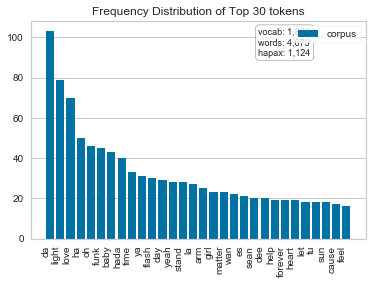

In [65]:
from sklearn.feature_extraction.text import CountVectorizer

from yellowbrick.text import FreqDistVisualizer

# Load the text data
corpus = load_hobbies()

vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(df_demo['nltk_lyrics'])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v',n=30)
visualizer.fit(docs)
visualizer.show()

In [66]:
#Control Panel - Hyper Parameters

#Count Vectorizer
max_features = 500 #500
max_df = .08



#LDA
n_topics = 3  #10


#LDA Display
display_n_chunks = 2 #5
n_topics = 10        #20
n_words = 5        #5



In [67]:
#Count Vectorizer
vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
X = vect.fit_transform(df_demo['nltk_lyrics'])

In [68]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=n_topics, learning_method="batch",
                                max_iter=15, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(n_topics), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words)

lda.components_.shape: (10, 500)
topic 0       topic 1       
--------      --------      
soup          leaving       
missy         driving       
icki          city          
supa          inner         
freak         youre         


topic 2       topic 3       
--------      --------      
da            senza         
funk          things        
hada          wonder        
ha            le            
flash         ti            


topic 4       topic 5       
--------      --------      
ha            arm           
forever       asleep        
voice         fell          
em            numb          
blue          sleep         


topic 6       topic 7       
--------      --------      
choppa        sean          
cold          girl          
loving        inside        
everybody     ass           
dagger        boys          


topic 8       topic 9       
--------      --------      
la            niggaz        
es            sing          
tu            eightball     
am

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [24]:
feature_names

array(['200', '3000', '40', ..., 'zuibun', 'zutto', 'ãºltima'],
      dtype='<U14')

## Topic Analysis

In [ ]:
lda = LatentDirichletAllocation(n_components=3)
    lda.fit(termFrequency)
    for idx, topic in enumerate(lda.components_):
        print ("Topic ", idx, " ".join(featureNames[i] for i in topic.argsort()[:-10 - 1:-1]))

## Create Spotify Playlist

In [ ]:
import requests
import json
import pandas as pd
import spotipy#authentication
import spotipy.util as util#authentication
from spotipy.oauth2 import SpotifyClientCredentials#authentication

In [ ]:
cid = '049ade7215e54c63a2b628f3784dc407'
secret = '5d30770120ad4dbbabbb5ce538110e05'
redirect_uri = 'http://google.com/'
username = 'name'

In [ ]:
#Authentication

scope = 'playlist-modify-private'
token_playlist = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_playlist:
    sp_playlist = spotipy.Spotify(auth=token_playlist)
else:
    print("Can't get token for", username)
    
#Authentication

scope = 'user-read-private'
token_user = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_user:
    sp_user = spotipy.Spotify(auth=token_user)
else:
    print("Can't get token for", username)

In [ ]:
def get_user_id(url):
    try:
        resp = requests.get(url,headers={'Authorization': 'Bearer ' + token_user},
                             #data={"name": "SSP"}
                           )
        
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
    
    response = resp.json()
    userid = response['id']
    
    return userid


In [ ]:
user_id = get_user_id('https://api.spotify.com/v1/me')

In [ ]:
identification = user_id
identification

In [ ]:
playlist = sp_playlist.user_playlist_create(identification,'SSP', public=False, description="First SSP")

In [ ]:
playlist

In [ ]:
playlist_tracks = sp_playlist.user_playlist_add_tracks(identification,playlist['id'],df_ssp['track_uri'], position=None)

## Rough

In [ ]:
#Pick from bag of words how many elements
from sklearn.decomposition import NMF, LatentDirichletAllocation
no_features = 500

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(decode_error='strict',#strip_accents=,
                                   stop_words='english',ngram_range=(1,1),
                                   max_df=0.95,min_df=2, 
                                   max_features=no_features#vocabulary=,
                                   #binary=,#norm=,
                                   #use_idf=True,
                                   #smooth_idf=True,
                                   #sublinear_tf=
                                   )


tfidf = tfidf_vectorizer.fit_transform(df_playlist['lyrics'].values.astype('U'))
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [ ]:
#Divide those elements into how many topics
no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {i}:".format(i=topic_idx))
        print([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        a = []
        b = a.append([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
       
        return a
#How many terms per topic
no_top_terms = 10
a = display_topics(nmf, tfidf_feature_names, no_top_terms)

In [ ]:
a[0]

In [ ]:
ssp = []
def playlist_element(lyrics,element,playlist_position):
    if(lyrics.find(element)!= -1):
        return playlist_position
    else:
        return None


for slot in range(len(a[0])):
    for element in a[0]:
#reset to org state
        df_playlist = df
        df_playlist['playlist_index_{s}'.format(s=slot)] = df_playlist.apply(lambda x: playlist_element(x['lyrics']
                                                                            ,element[slot],slot),axis=1)
        x = df_playlist.dropna()
        y = x[(x['valence'] == x['valence'].max())]
        z = y[(y['energy'] == y['energy'].max())]
        
        print(z.track_uri.values[0])
        ssp.append({'artist_name':z.artist_name.values[0],'track_name':z.track_name.values[0],'track_uri':z.track_uri.values[0],
                   'valence':y.valence.values[0],'energy':z.energy.values[0],'lyrics':z.lyrics.values[0]})
        
        df_playlist = df_playlist.drop(index=z.index)


In [ ]:
df_ssp = pd.DataFrame(ssp)
df_ssp

## Visualization (Valence Curve, Energy Curve)

In [ ]:
df_ssp.plot.line(x='valence',y='energy')

## unigrams

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {i}:".format(i=topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#How many words per topic
no_top_words = 4
display_topics(nmf, tfidf_feature_names, no_top_words)